In [1]:
import sys

sys.path.append('/home/andresf/workspace/satellite-images-segmentation/')

In [2]:
import numpy as np
import os
import torch

from codebase.data.satellite import PermafrostDataset
from codebase.models.classification import resnet18
from codebase.utils.metrics import binary_accuracy
from codebase.utils.transforms import Normalize, Rescale, ToTensor
from torch.utils.data import DataLoader
from torchvision import transforms

home_dir = os.environ['HOME']

test_transform = transforms.Compose([Normalize(),
                                     Rescale(),
                                     ToTensor()])

test_dataset = PermafrostDataset(data_dir=f'{home_dir}/data/permafrost-imagery/',
                                 class_id=0,
                                 is_train=False,
                                 transform=test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=16,
                             shuffle=False, num_workers=4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = resnet18(num_classes=1, num_channels=7).to(device)

model_checkpoint = torch.load(f'{home_dir}/checkpoints/resnet18-roads/best_dev.pt',
                              map_location=torch.device('cpu'))

model.load_state_dict(model_checkpoint['model_state_dict'])

model.eval()

ResNet(
  (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
running_accuracy = 0.0

for batch_idx, sample in enumerate(test_dataloader):
    print(batch_idx)
    inputs, labels = sample['image'].to(device), sample['label'].to(device)
    labels = labels.float()
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        accuracy = binary_accuracy(outputs, labels.unsqueeze(1))
    running_accuracy += accuracy.item() * inputs.size(0)

epoch_accuracy = running_accuracy / len(test_dataset)

In [3]:
import pandas as pd

home_dir = os.environ['HOME']
data_dir = f'{home_dir}/data/permafrost-imagery'

_df_ground_truth = pd.read_csv(f'{data_dir}/train_wkt.csv',
                               names=['ImageId', 'ClassType', 'MultipolygonWKT'], skiprows=1)

_df_grid_sizes = pd.read_csv(f'{data_dir}/grid_sizes.csv',
                             names=['ImageId', 'Xmax', 'Ymin', 'Xmin', 'Ymax'], skiprows=1)

In [ ]:
list(_df_ground_truth.ImageId.unique())

In [11]:
from utils.data_utils import ImageData

# 23 2020-07-04-17-38-15 27

# img_key = 'gillam_mb_canada_2020-07-04-17-38-15_eopatch-0023'
# img_key = 'gillam_mb_canada_2020-01-11-17-38-07_eopatch-0001'
img_key = 'gillam_mb_canada_2020-07-04-17-38-15_eopatch-0017'
# img_key = 'gillam_mb_canada_2020-04-20-17-38-14_eopatch-0013'

image_data = ImageData(data_dir, img_key, _df_ground_truth, _df_grid_sizes)
image_data.create_train_feature()
image_data.create_label()

sample = {'image': image_data.train_feature,
          'label': [int(image_data.label[..., 0].sum(axis=(0, 1)) > 0)]}

In [12]:
from codebase.utils.transforms import Normalize, Rescale, ToTensor
from torchvision import transforms

transform = transforms.Compose([Normalize(),
                                Rescale(),
                                ToTensor()])

sample = transform(sample)

print(sample['image'].shape)
print(sample['label'].shape)

torch.Size([7, 500, 500])
torch.Size([1])


In [13]:
from codebase.utils.metrics import binary_accuracy

inputs, labels = sample['image'].to(device), sample['label'].to(device)

labels = labels.float()

with torch.set_grad_enabled(False):
    outputs = model(torch.unsqueeze(inputs, 0))

accuracy = binary_accuracy(outputs, labels.unsqueeze(1))

print(labels, torch.sigmoid(outputs), accuracy)

tensor([1.]) tensor([[0.9819]]) tensor(1.)


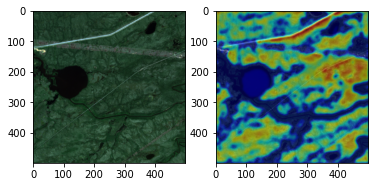

In [17]:
from matplotlib import pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.layer1[-1]]
targets = [ClassifierOutputTarget(0)]

cam = GradCAM(model=model,
              target_layers=target_layers,
              use_cuda=torch.cuda.is_available())

grayscale_cam = cam(input_tensor=torch.unsqueeze(inputs, 0),
                    targets=targets)

rgb_img = (np.transpose(inputs.numpy(), (1, 2, 0))[..., 0:3] + 1.0) / 2

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(rgb_img)
axes[1].imshow(visualization)